# Multiple regression w/ Pytorch

Multiple linear regression is the most common form of linear regression analysis.  As a predictive analysis, the multiple linear regression is used to explain the relationship between one continuous dependent variable and two or more independent variables. 

## Problem statement

Given data counting bike sharing statistics, predict future demand for bikes.

Bike sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back to another position. Currently, there are about over 500 bike-sharing programs around the world which are composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real-world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system in Washington, DC with the corresponding weather and seasonal information.

https://www.kaggle.com/marklvl/bike-sharing-dataset

## Preparation

### Installing libraries

In [2]:
!pip install graphviz
!pip install hiddenlayer

In [3]:
import torch
import hiddenlayer as hl

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Downloading the data

The original data is in the link below. However, the data used to have a categorical collumn "season" { spring, summer, ... }. But currently the data is already using integer encoding. I reversed the encoding below (part: "Reversing the integer encoding") bringing back the format of the data as it was before.


In [6]:
# https://www.kaggle.com/marklvl/bike-sharing-dataset
# !wget https://www.kaggle.com/marklvl/bike-sharing-dataset/download -O data.zip # need to add auth data


!unzip -n *archive.zip
# !rm -rf bike-sharing-dataset/
!rm -f *.txt *.csv
!rm -f my_model

Archive:  28865_36778_bundle_archive.zip
  inflating: Readme.txt              
  inflating: bike-sharing-dataset/Readme.txt  
  inflating: bike-sharing-dataset/day.csv  
  inflating: bike-sharing-dataset/hour.csv  
  inflating: day.csv                 
  inflating: hour.csv                


### Loading the data

In [7]:
data = pd.read_csv('./bike-sharing-dataset/hour.csv', index_col=0)

In [8]:
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Reversing the integer encoding

In [9]:
data["season"].replace({1: "spring", 2: "summer", 3: "fall", 4: "winter"}, inplace=True)
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,spring,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,spring,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,spring,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,spring,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,spring,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Exploring the data

### Shape

In [10]:
data.shape

(17379, 16)

### Visualizing relationships

- We see that for both the years fall is the most popular season for bike rentals.
- The Bike rentals seem to have increased in one year

Text(0.5, 1.0, 'Number of bikes rented per season')

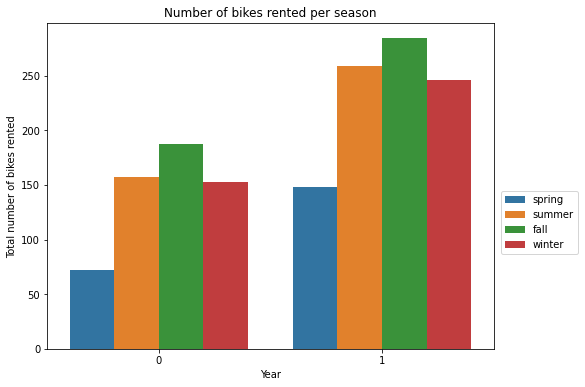

In [11]:
plt.figure(figsize=(8, 6))

sns.barplot('yr', 'cnt', hue = 'season', data = data, ci=None)

plt.legend(loc = 'upper right', bbox_to_anchor=(1.2,0.5))

plt.xlabel('Year')
plt.ylabel('Total number of bikes rented')

plt.title('Number of bikes rented per season')

- workingday: If day is neither weekend nor holiday is 1, otherwise is 0
- we see that when it is not a working day more bikes are rented for all months

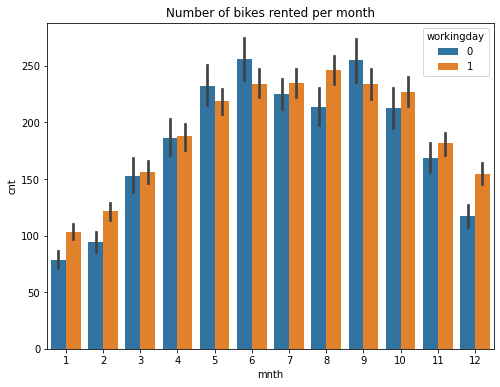

In [12]:
plt.figure(figsize=(8, 6))

sns.barplot(x = 'mnth', y = 'cnt', hue = 'workingday', data = data)

plt.title('Number of bikes rented per month')
plt.show()

- number of bikes rented are higher for high temperature

Text(0, 0.5, 'Total number of bikes rented')

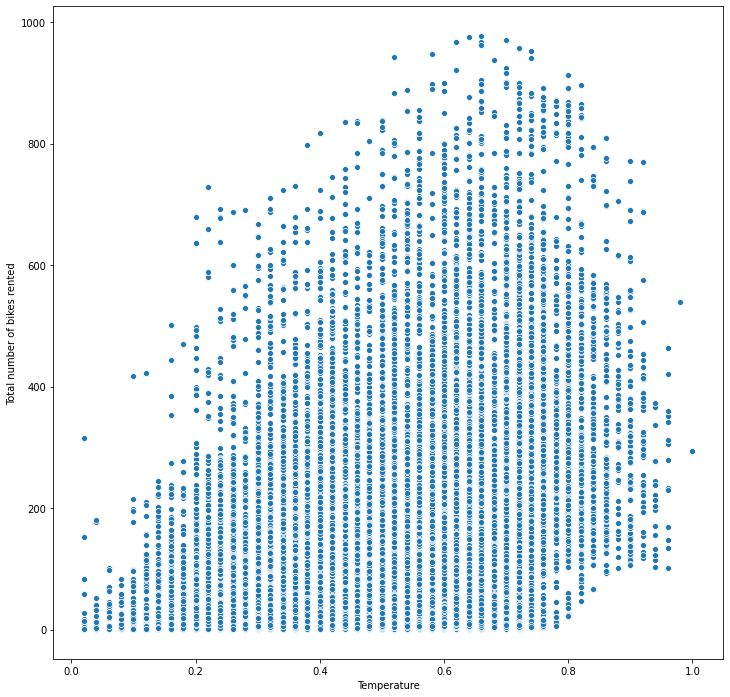

In [13]:
plt.figure(figsize=(12, 12))

fig = sns.scatterplot(x = 'temp', y = 'cnt', data = data)

plt.xlabel('Temperature')
plt.ylabel('Total number of bikes rented')

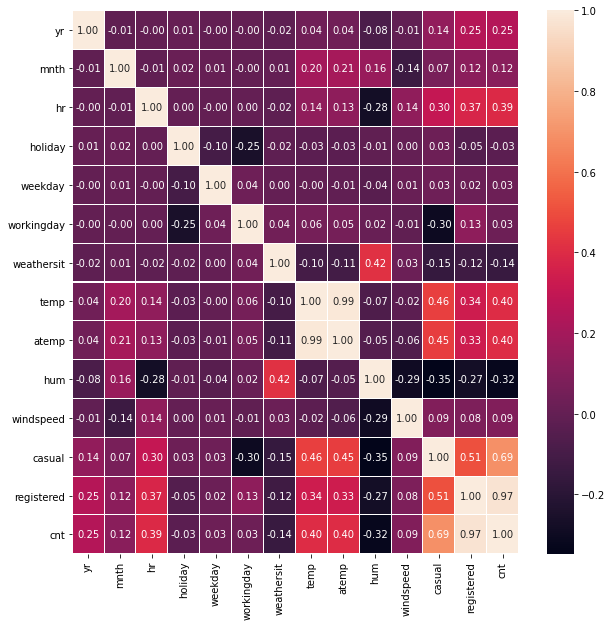

In [14]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=0.05, fmt= '.2f')
plt.show()

## Feature engineering

### Perform one-hot encoding on categorical column season 

In [15]:
data.sample(5)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
3727,2011-06-09,summer,0,6,4,0,4,1,2,0.72,0.6970,0.79,0.0896,2,4,6
4880,2011-07-27,fall,0,7,5,0,3,1,1,0.70,0.6515,0.54,0.2836,0,18,18
13731,2012-07-31,fall,1,7,7,0,2,1,1,0.68,0.6364,0.83,0.2239,21,492,513
12158,2012-05-26,summer,1,5,18,0,6,0,2,0.76,0.6970,0.52,0.1940,199,216,415
16147,2012-11-10,winter,1,11,12,0,6,0,1,0.48,0.4697,0.48,0.0000,258,348,606


In [16]:
data = pd.get_dummies(data, columns= ['season'])

In [17]:
data.sample(5)

,dteday,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_fall,season_spring,season_summer,season_winter
instant,,,,,,,,,,,,,,,,,,,
13136,2012-07-06,1,7,12,0,5,1,1,0.88,0.7576,0.28,0.1045,111,220,331,1,0,0,0
10731,2012-03-28,1,3,5,0,3,1,1,0.36,0.3333,0.43,0.2985,2,38,40,0,0,1,0
13639,2012-07-27,1,7,11,0,5,1,1,0.84,0.7727,0.47,0.3284,67,184,251,1,0,0,0
4750,2011-07-21,0,7,19,0,4,1,1,0.86,0.9242,0.67,0.2836,51,233,284,1,0,0,0
6363,2011-09-27,0,9,16,0,2,1,2,0.66,0.6061,0.83,0.1940,33,225,258,0,0,0,1


### Choose the following features to perform regression

In [18]:
columns = ['registered', 'holiday', 'weekday', 
           'weathersit', 'temp', 'atemp',
           'season_fall', 'season_spring', 
           'season_summer', 'season_winter']

features = data[columns]

In [19]:
features.head()

,registered,holiday,weekday,weathersit,temp,atemp,season_fall,season_spring,season_summer,season_winter
instant,,,,,,,,,,
1,13,0,6,1,0.24,0.2879,0,1,0,0
2,32,0,6,1,0.22,0.2727,0,1,0,0
3,27,0,6,1,0.22,0.2727,0,1,0,0
4,10,0,6,1,0.24,0.2879,0,1,0,0
5,1,0,6,1,0.24,0.2879,0,1,0,0


### Count is our target variable

In [20]:
target = data[['cnt']]

In [21]:
target.head()

,cnt
instant,
1,16
2,40
3,32
4,13
5,1


## Data loading and splitting

### Create training and test data using train_test_split

In [22]:
from sklearn.model_selection import train_test_split

### Split the data into two chunks - 80% for training and 20% for testing 


In [23]:
X_train, x_test, Y_train, y_test = train_test_split(features, target, test_size=0.2)

If it's a time series data, why can we just split it like that? We know that train_test_split() produces a random split, however while splitting like this we simply subdivide the data randomly and the pattern of bike shares increasing "as the days go by" is still there. 

More concretelly we would be training a time series model with data missing. This is not ideal (that is why we ommited date dimension) and is a topic worthy of separate discusion which would be centered around "dealing with time series data", "splitting time series data", "time based cross validation", "rolling window analysis", etc.

https://stats.stackexchange.com/questions/117350/how-to-split-dataset-for-time-series-prediction

https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8

### Converting data in pytorch tensors

In [24]:
X_train_tensor = torch.tensor(X_train.values, dtype = torch.float)
x_test_tensor = torch.tensor(x_test.values, dtype = torch.float)

Y_train_tensor = torch.tensor(Y_train.values, dtype = torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float)

In [25]:
X_train_tensor.shape

torch.Size([13903, 10])

In [26]:
Y_train_tensor.shape

torch.Size([13903, 1])

In [27]:
import torch.utils.data as data_utils 

torch.utils.data.TensorDataset(*tensors) - Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.

In [28]:
train_data = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)

torch.utils.data.DataLoader -  Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

torch.utils.data.DataLoader provides

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers

In [29]:
train_loader = data_utils.DataLoader(train_data, batch_size=1000, shuffle=True)

In [30]:
len(train_loader)

14

In [31]:
features_batch, target_batch = iter(train_loader).next()

In [32]:
features_batch.shape

torch.Size([1000, 10])

In [33]:
target_batch.shape

torch.Size([1000, 1])

## NN Definition

### Define the parameters for the neural network
* <b>inp</b> sets the input size  matching the shape of the X_train_tensor. 
* <b>out</b> will be used to set the size of the output from the neural network. We only predict a single output for each day, so this will be 1
* <b>hid</b> is used to set the number of hidden neurons in our neural network
* <b>loss_fn</b> is MSELoss since we're performing a linear regression

In [34]:
inp = X_train_tensor.shape[1]
out = 1

hid = 10

loss_fn = torch.nn.MSELoss()

<b>nn.Sequential:</b>
Use the nn package to define our model as a sequence of layers. nn.Sequential is a Module which contains other Modules, and applies them in sequence to produce its output. Each Linear Module computes output from input using a linear function, and holds internal Tensors for its weight and bias.

<b>nn.Linear: </b> Applies a linear transformation to the incoming data: y=Ax+b<br>
parameters:<br>
in_features – size of each input sample
out_features – size of each output sample
bias – If set to False, the layer will not learn an additive bias. Default: True

<b>Sigmoid : </b>Applies the element-wise function Sigmoid(x)= 1 / (1+exp(−x))


<b>Dropout : </b>During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.

### Creating model using nn.Sequential

Steps:
- first run only with two linear layer
- then run ReLU linear
- then use dropout with all the layers to regularise the model

### Only linear layers are enough for this simple problem.

In [35]:
# model = torch.nn.Sequential(torch.nn.Linear(inp, hid),
#                             torch.nn.Linear(hid, out))

# model = torch.nn.Sequential(torch.nn.Linear(inp, hid),
#                             torch.nn.ReLU(),
#                             torch.nn.Linear(hid, out))

model = torch.nn.Sequential(torch.nn.Linear(inp, hid),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(p=0.2),
                            torch.nn.Linear(hid, out))

# model = torch.nn.Sequential(torch.nn.Linear(inp, hid),
#                             torch.nn.Sigmoid(),
#                             torch.nn.Linear(hid, out))

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:438: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


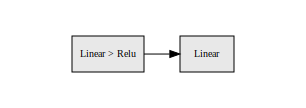

In [36]:
hl.build_graph(model, torch.zeros([10, inp]))

### optimizer object will hold the current state and will update the parameters based on the computed gradients.
optim.Adam Implements Adam algorithm.

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Training our model

Foward Pass:
* Predicting Y with input data X

Finding Loss:
* Finding difference between Y_train_tensor(target) and output using MSEloss function defined above


Back Propagation:
* starting with zero gradients before back propogation
* back propogation is done by simply loss.backward() function

optimizer step
* All optimizers implement a step() method, that updates the parameters.
* reducing weight with multiple of learning rate and gradient

In [38]:
total_step = len(train_loader)
print(total_step)

14


In [39]:
num_epochs = 100

for epoch in range(num_epochs + 1):
    for i, (features, target) in enumerate(train_loader):
        output = model(features)
        loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/100], Step [1/14], Loss: 65125.9570
Epoch [1/100], Step [2/14], Loss: 63931.5586
Epoch [1/100], Step [3/14], Loss: 60288.7617
Epoch [1/100], Step [4/14], Loss: 62720.0195
Epoch [1/100], Step [5/14], Loss: 59145.5703
Epoch [1/100], Step [6/14], Loss: 65376.5742
Epoch [1/100], Step [7/14], Loss: 59955.7539
Epoch [1/100], Step [8/14], Loss: 60502.2695
Epoch [1/100], Step [9/14], Loss: 67315.3203
Epoch [1/100], Step [10/14], Loss: 61571.8242
Epoch [1/100], Step [11/14], Loss: 65050.6094
Epoch [1/100], Step [12/14], Loss: 64975.9258
Epoch [1/100], Step [13/14], Loss: 59725.0078
Epoch [1/100], Step [14/14], Loss: 63222.2148
Epoch [11/100], Step [1/14], Loss: 37634.8711
Epoch [11/100], Step [2/14], Loss: 33467.0664
Epoch [11/100], Step [3/14], Loss: 38451.0703
Epoch [11/100], Step [4/14], Loss: 38699.4883
Epoch [11/100], Step [5/14], Loss: 39494.9258
Epoch [11/100], Step [6/14], Loss: 37840.8555
Epoch [11/100], Step [7/14], Loss: 37626.9844
Epoch [11/100], Step [8/14], Loss: 36986.41

## Using model for predictions
We pick one of the days from the test data set for predictions

- model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval model instead of training mode.

In [40]:
model.eval()

with torch.no_grad():
    y_pred = model(x_test_tensor)

In [41]:
sample = x_test.iloc[41]
sample

registered       289.0000
holiday            0.0000
weekday            4.0000
weathersit         1.0000
temp               0.6400
atemp              0.5909
season_fall        1.0000
season_spring      0.0000
season_summer      0.0000
season_winter      0.0000
Name: 5410, dtype: float64

### We convert these features to a Pytorch tensor

In [42]:
sample_tensor = torch.tensor(sample.values, 
                             dtype = torch.float)
sample_tensor

tensor([289.0000,   0.0000,   4.0000,   1.0000,   0.6400,   0.5909,   1.0000,
          0.0000,   0.0000,   0.0000])

### Compare the actual and predicted values for this particular data point
The predicted count is quite close to the actual one

In [43]:
with torch.no_grad():
    y_pred = model(sample_tensor)

print("Predicted count : ", (y_pred.item()))
print("Actual count : ", (y_test.iloc[41]))

Predicted count :  330.7688903808594
Actual count :  cnt    308
Name: 5410, dtype: int64


### Performing predictions on the entire test set
We get the list of predicted values in a tensor

In [44]:
with torch.no_grad():
    y_pred_tensor = model(x_test_tensor)

### The tensor is converted to a numpy array

In [45]:
y_pred = y_pred_tensor.detach().numpy()

y_pred.shape

(3476, 1)

In [46]:
y_test.values.shape

(3476, 1)

In [47]:
compare_df = pd.DataFrame({'actual': np.squeeze(y_test.values), 'predicted': np.squeeze(y_pred)})

compare_df.sample(20)

,actual,predicted
356,374,386.054962
216,154,145.837891
3065,5,13.143284
3412,207,195.062958
3469,19,25.965567
3198,472,454.161102
590,227,221.708740
3057,124,120.434196
2749,62,66.846710
1882,5,8.583128


## r2 score

In [48]:
from sklearn.metrics import mean_absolute_error

print(sklearn.metrics.r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

# L -> L
# 0.947522541648828
# 24.4707706184464

# L w/ Relu -> L
# 0.9489632905556128
# 23.006869639502572

# L w/ Relu -> L
# 0.939177669114976
# 22.81379715507149

0.9405900945835447
23.583749021636056


## Plot a graph of the predicted count against the actual count

it is forming a  linear relationship

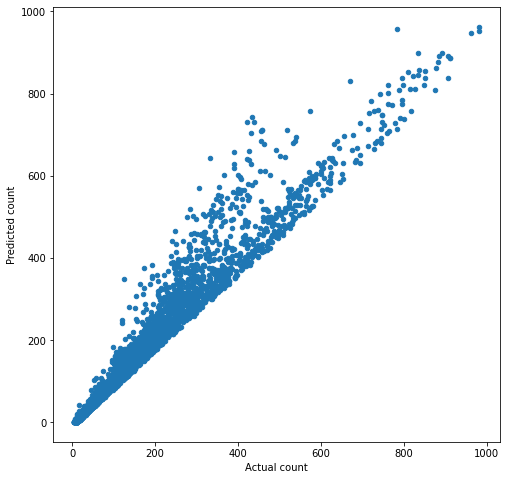

In [49]:
plt.figure(figsize=(8, 8))

plt.scatter(y_pred, y_test.values, s=20)

plt.xlabel("Actual count")
plt.ylabel("Predicted count")

plt.show()

### Plot the actual and predicted values
We see that actual and predicted count are quite close

In [50]:
plt.figure(figsize=(900, 20))

plt.plot(y_pred, label='Predicted count')
plt.plot(y_test.values, label='Actual count')

plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### TODO :: add stacked bar chart

https://python-graph-gallery.com/stacked-barplot/

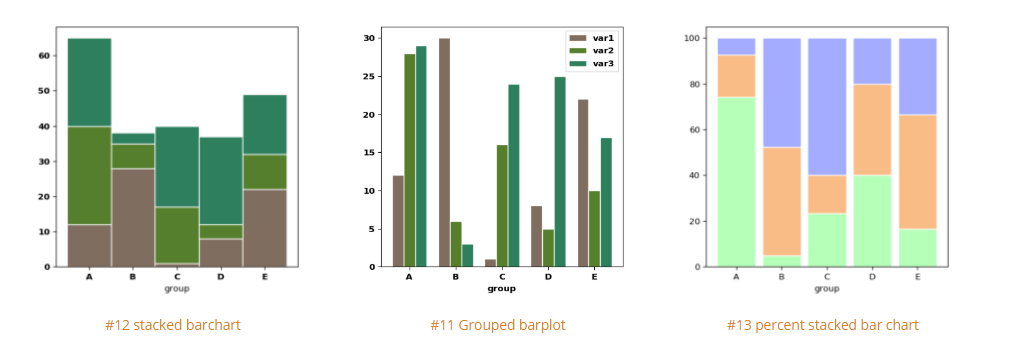

## Saving and restoring the model

### Saving our trained model
Pytorch allows our model to be saved. The parameters to the torch.save() method are the model to be saved followed by the directory path where it should be saved

In [51]:
torch.save(model, 'my_model')

In [52]:
!ls 

28865_36778_bundle_archive.zip	bike-sharing-dataset  my_model	sample_data


### Loading  an already saved model
We can load a saved model using the torch.load() method

In [53]:
saved_model = torch.load('my_model')

### We now use the saved model to perform predictions
It is now used exactly how we used the model before it was saved

In [54]:
y_pred_tensor = saved_model(x_test_tensor)

In [55]:
y_pred = y_pred_tensor.detach().numpy()
y_pred

array([[600.29083 ],
       [ 65.762985],
       [134.39859 ],
       ...,
       [530.5871  ],
       [ 32.22389 ],
       [ 23.699474]], dtype=float32)

## Validation against a RandomForrest

A random forest is one of the most easy to use and understant ML models that is very powerfull for tabular data. We would use a Tree based model, then a RandomForrest and try to beat them in normal circumstances. For now, let's compare how our NN performs against a RandomForrest.

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd

data = pd.read_csv('./bike-sharing-dataset/hour.csv', index_col=0)

columns = ['registered', 'holiday', 'weekday', 'weathersit', 'temp', 'atemp', 'season']

features = data[columns]
target = data[['cnt']]

X_train, x_test, Y_train, y_test = train_test_split(features, target, test_size=0.2)

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, Y_train.values.ravel())
preds = forest_model.predict(x_test)

In [66]:
# validation
print(r2_score(y_test, preds))
print(mean_absolute_error(y_test, preds))

compare_df = pd.DataFrame({'actual': np.squeeze(y_test.values), 'predicted': np.squeeze(preds)})
compare_df.sample(20)

0.9861213641140333
12.60562871139058


,actual,predicted
2238,304,336.700000
2918,2,2.165667
1228,119,101.766667
3238,233,274.420000
3219,209,225.820000
1301,139,133.023333
913,436,413.340000
139,297,293.590000
2474,78,77.940000
217,129,160.783333


# Todo:

- /usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:438: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
- All code in one place
- Validation against another model (DecisionTree)
- **[DONE]** Vlidation against another model (RandomForest)
- Add handling for date in all the models
